In [49]:
# load the libraries we are using 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
import sklearn
from sklearn.preprocessing import LabelEncoder

%matplotlib inline 

In [50]:
# load the data
train_data_frame = pd.read_csv("train.csv", index_col = 0)
test_data_frame = pd.read_csv("test.csv", index_col = 0)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
524           60       RL        130.0    40094   Pave   NaN      IR1   
692           60       RL        104.0    21535   Pave   NaN      IR1   
1183          60       RL        160.0    15623   Pave   NaN      IR1   
1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig    ...     PoolArea PoolQC  Fence  \
Id                                      ...                              
524          Bnk    AllPub    Inside    ...            0    NaN    NaN   
692          Lvl    AllPub    Corner    ...            0    NaN    NaN   
1183         Lvl    AllPub    Corner    ...          555     Ex  MnPrv   
1299         Bnk    AllPub    Corner    ...          480     Gd    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                    

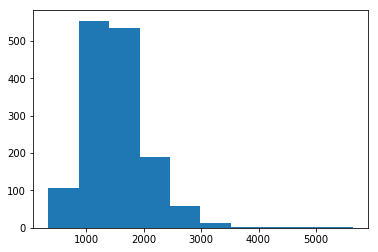

In [51]:
# dealing with outliers
plt.hist(train_data_frame["GrLivArea"])
print (train_data_frame[train_data_frame["GrLivArea"]>4000])
# a few houses has general living area more than 4000, we drop it (TODO: other variables 
train_data_frame.drop(train_data_frame[train_data_frame["GrLivArea"]>4000].index, inplace=True)

In [52]:
# drop columns according to the rules below: 
# 1. drop "LotFrontage": to many NA values (use alternative, preserve information)
# 2. drop "MSSubClass": information already reflected in other variables (e.g. BldgType, HouseStyle, YearBuilt, YearRemodAdd)
# 3. drop "Utilities": testing data all the same - AllPub (No information)
train_data_frame_trimmed = train_data_frame.drop(['MSSubClass', 'Utilities'], axis = 1)
# do the same to test dataset 
test_data_frame_trimmed = test_data_frame.drop(['MSSubClass', 'Utilities'], axis = 1)

# Alternatively, filling LotFrontage with median based on neighborhood
lot_frontage_group_train = train_data_frame['LotFrontage'].groupby(train_data_frame["Neighborhood"])
for key, group in lot_frontage_group_train: 
    flag = (train_data_frame_trimmed['Neighborhood'] == key) & (train_data_frame_trimmed['LotFrontage'].isnull())
    train_data_frame_trimmed.loc[flag, 'LotFrontage'] = group.median()
# do it the testing in the same way
lot_frontage_group_test = test_data_frame['LotFrontage'].groupby(test_data_frame["Neighborhood"])
for key, group in lot_frontage_group_test: 
    flag = (test_data_frame_trimmed['Neighborhood'] == key) & (test_data_frame_trimmed['LotFrontage'].isnull())
    test_data_frame_trimmed.loc[flag, 'LotFrontage'] = group.median()

In [53]:
# Factorize categorical features into ordinal numbers
# @param df: original dataframe
# @param factor_df: dataframe containing categorical variables needed to be transformed 
# @param column: list of categorical variables' name 
# @param fill_na: whether need to fill NA in categorical variable 
# @return factor_df: dataframe after factorization 
le = LabelEncoder()
def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

In [54]:
# Deal with NA in columns
# first deal with numerical columns
train_data_frame_trimmed['MasVnrArea'].fillna(0.0, inplace = True)
train_data_frame_trimmed['GarageYrBlt'].fillna(1980.0, inplace = True)
test_data_frame_trimmed['MasVnrArea'].fillna(0.0, inplace = True)
test_data_frame_trimmed['GarageYrBlt'].fillna(1980.0, inplace = True)

In [55]:
# some of the NAs are created because the house doesn't have the feature, rather than missing data
# for ordinal columns, transform it into numbers
# With Missing values

levels = {'No' : 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
ord_list = ['GarageQual','GarageCond','FireplaceQu', 'BsmtCond', 'BsmtQual', 'PoolQC']
for name in ord_list:
    train_data_frame_trimmed[name].fillna('No', inplace = True)
    train_data_frame_trimmed[name] = train_data_frame_trimmed[name].map(levels).astype(int)
    
train_data_frame_trimmed['BsmtExposure'].fillna('N', inplace = True)
train_data_frame_trimmed['BsmtExposure'] = train_data_frame_trimmed['BsmtExposure'].map(
    {'N': 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

levels_2 = {'N': 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
train_data_frame_trimmed['BsmtFinType1'].fillna('N', inplace = True)
train_data_frame_trimmed['BsmtFinType1'] = train_data_frame_trimmed['BsmtFinType1'].map(levels_2).astype(int)
train_data_frame_trimmed['BsmtFinType2'].fillna('N', inplace = True)
train_data_frame_trimmed['BsmtFinType2'] = train_data_frame_trimmed['BsmtFinType2'].map(levels_2).astype(int)

train_data_frame_trimmed['GarageFinish'].fillna('N', inplace = True)
train_data_frame_trimmed['GarageFinish'] = train_data_frame_trimmed['GarageFinish'].map(
    {'N': 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)


train_data_frame_trimmed['Fence'].fillna('N', inplace = True)
train_data_frame_trimmed['Fence'] = train_data_frame_trimmed['Fence'].map(
    {'N': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
# without missing values, but clearly ordinal 
ordinal_list = ['ExterQual','ExterCond','HeatingQC', 'KitchenQual']
for name in ordinal_list: 
    train_data_frame_trimmed[name] = train_data_frame_trimmed[name].map(levels).astype(int)

train_data_frame_trimmed['Functional'] = train_data_frame_trimmed['Functional'].map(
    {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

In [56]:
# Specialized treatment for test dataset
test_data_frame_trimmed['MSZoning'].fillna('RL', inplace = True) # mode
test_data_frame_trimmed['Exterior1st'].fillna('Viny1Sd', inplace = True) # mode
test_data_frame_trimmed['Exterior2nd'].fillna('VinylSd', inplace = True) # mode
test_data_frame_trimmed['BsmtFinSF1'].fillna(439.0, inplace = True) #mean
test_data_frame_trimmed['BsmtFinSF2'].fillna(53.0, inplace = True) #mean
test_data_frame_trimmed['BsmtUnfSF'].fillna(554.0, inplace = True) #mean
test_data_frame_trimmed['TotalBsmtSF'].fillna(1046.0, inplace = True) #mean
test_data_frame_trimmed['BsmtFullBath'].fillna(0.0, inplace = True) #Mode & mean
test_data_frame_trimmed['BsmtHalfBath'].fillna(0.0, inplace = True)# MOde & mean
test_data_frame_trimmed['KitchenQual'].fillna('TA', inplace = True) # mode
test_data_frame_trimmed['Functional'].fillna('Typ', inplace = True)# mode
test_data_frame_trimmed['GarageCars'].fillna(2.0, inplace = True) # mode
test_data_frame_trimmed['GarageArea'].fillna(473.0, inplace = True) # mean
test_data_frame_trimmed['SaleType'].fillna('WD', inplace = True) # mode

In [57]:
# Same for the testing dataset (just copy & paste from above cell)
# some of the NAs are created because the house doesn't have the feature, rather than missing data
# for ordinal columns, transform it into numbers
# With Missing values

levels = {'No' : 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
ord_list = ['GarageQual','GarageCond','FireplaceQu', 'BsmtCond', 'BsmtQual', 'PoolQC']
for name in ord_list:
    test_data_frame_trimmed[name].fillna('No', inplace = True)
    test_data_frame_trimmed[name] = test_data_frame_trimmed[name].map(levels).astype(int)
    
test_data_frame_trimmed['BsmtExposure'].fillna('N', inplace = True)
test_data_frame_trimmed['BsmtExposure'] = test_data_frame_trimmed['BsmtExposure'].map(
    {'N': 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

levels_2 = {'N': 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
test_data_frame_trimmed['BsmtFinType1'].fillna('N', inplace = True)
test_data_frame_trimmed['BsmtFinType1'] = test_data_frame_trimmed['BsmtFinType1'].map(levels_2).astype(int)
test_data_frame_trimmed['BsmtFinType2'].fillna('N', inplace = True)
test_data_frame_trimmed['BsmtFinType2'] = test_data_frame_trimmed['BsmtFinType2'].map(levels_2).astype(int)

test_data_frame_trimmed['GarageFinish'].fillna('N', inplace = True)
test_data_frame_trimmed['GarageFinish'] = test_data_frame_trimmed['GarageFinish'].map(
    {'N': 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)


test_data_frame_trimmed['Fence'].fillna('N', inplace = True)
test_data_frame_trimmed['Fence'] = test_data_frame_trimmed['Fence'].map(
    {'N': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
# without missing values, but clearly ordinal 
ordinal_list = ['ExterQual','ExterCond','HeatingQC', 'KitchenQual']
for name in ordinal_list: 
    test_data_frame_trimmed[name] = test_data_frame_trimmed[name].map(levels).astype(int)

test_data_frame_trimmed['Functional'] = test_data_frame_trimmed['Functional'].map(
    {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

In [58]:
for i, name in enumerate(train_data_frame_trimmed.columns):
    if sum(pd.isna(train_data_frame_trimmed[name])) > 0:
        print (name, sum(pd.isna(train_data_frame_trimmed[name])))

Alley 1365
MasVnrType 8
Electrical 1
GarageType 81
MiscFeature 1402


In [59]:
# Others
train_data_frame_trimmed['Alley'].fillna('No Alley', inplace = True)
train_data_frame_trimmed['MiscFeature'].fillna('No MiscFeatures', inplace = True)
train_data_frame_trimmed['MasVnrType'].fillna('None', inplace = True)
train_data_frame_trimmed['GarageType'].fillna('Attchd', inplace = True)
train_data_frame_trimmed['Electrical'].fillna('Sbrkr', inplace = True)
# Transform Central Air to 0,1 
train_data_frame_trimmed["CentralAir"] = train_data_frame_trimmed["CentralAir"].astype('category')
train_data_frame_trimmed["CentralAir"] = train_data_frame_trimmed["CentralAir"].cat.codes

In [60]:
# Misunderstanding
test_data_frame_trimmed['Alley'].fillna('No Alley', inplace = True)
test_data_frame_trimmed['MiscFeature'].fillna('No MiscFeatures', inplace = True)
test_data_frame_trimmed['MasVnrType'].fillna('None', inplace = True)
test_data_frame_trimmed['GarageType'].fillna('Attchd', inplace = True)
test_data_frame_trimmed['Electrical'].fillna('Sbrkr', inplace = True)
# Transform Central Air to 0,1 
test_data_frame_trimmed["CentralAir"] = test_data_frame_trimmed["CentralAir"].astype('category')
test_data_frame_trimmed["CentralAir"] = test_data_frame_trimmed["CentralAir"].cat.codes

In [61]:
test_NA_name = []
for i, name in enumerate(test_data_frame_trimmed.columns):
    if sum(pd.isna(test_data_frame_trimmed[name])) > 0:
        print (name, sum(pd.isna(test_data_frame_trimmed[name])))
        test_NA_name.append(name)
        

In [63]:
train_data_frame_trimmed.to_csv('train_trimmed.csv')
test_data_frame_trimmed.to_csv('test_trimmed.csv')